# Introduction



### Goal

The goal of this project is to evaluate different parameters that affect the performance of a Recurrent Neural Network (RNN) aimed at predicting the stock price, build and train the best performing network and evaluate it.

For this project I constructed a sequential neural network consisting of two layers:
1. RNN layer with 100 units initially (random number, which is tuned later), Rectified Linear Unit (RELU) activtion function, which is commonly used and I belive suits this task, and an input shape that is adjusted dependeing on the input data.
2. Regual Dense layer with 1 unit for the output (price prediction).

The neural network will be compiled using Adam optimizer to improve the accuracy duing deep learning and will be evaluated using the Mean Squared Error (MSE).

```python
model = Sequential()
model.add(SimpleRNN(units = 100, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
```

### This Project Uses the Stock Market Dataset from kaggle.com

The dataset is available [here](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset). In this project I uploaded the dataset to my Google Drive for convenience.

# Mounting Google Drive

I use my drive here for easier access to the data.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [13]:
# Deep Learning, Neural Networks, RNNs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Data Managment
import numpy as np
import pandas as pd

# Data Presentation
from matplotlib import pyplot as plt

# Others
import os
import random
from typing import Union

# Loading Data

## Data Loading and Cleaning Functions

In [14]:
def clean_dataframe(df: pd.DataFrame) -> bool:
    """ function which cleans and modyfies the dataset
    the function returns True if the dataframe was cleaned succesfully and can be
    used further and False if there are more than two consequent missing values
    for some of the inputs """

    def fill_nan(row: int, column: str) -> Union[int, float]:
        """ helper function which attempts to calculate the value to be
        filled into the empty cell at (row, col) by calculating the average
        of the previous and next values

        if one of the adjacent values is also empty, the function returns None """

        # checking if the first row
        if row == 0:

            # checking if the next values does not exist
            if pd.isna(df.at[i + 1, column]):
                return None
            else:
                return df.at[i + 1, column]

        # checking if the last row
        elif row == len(df) - 1:

            # checking if the previous value does not exist
            if pd.isna(df.at[i - 1, column]):
                return None
            else:
                return df.at[i - 1, column]

        # otherwise, calculate the average of the previous and next if possible
        else:

            if pd.isna(df.at[i - 1, column]) or pd.isna(df.at[i + 1, column]):
                return None
            else:

                # checking if the values are integers
                if type(df.at[i - 1, column]) == int:
                    return (df.at[i - 1, column] + df.at[i + 1, column]) // 2

                # otherwise, assume those are floats
                else:
                    return (df.at[i - 1, column] + df.at[i + 1, column]) / 2

    # iterating over the columns of the dataframe
    for column in df.columns:

        # iterating over row indices
        for i in range(len(df)):

            # checking if the cell is NaN
            if pd.isna(df.at[i, column]):

                # calculating the value to be filled
                fill_val = fill_nan(i, column)

                # checking if it was impossible to calculate the value
                if fill_val == None:

                    # function rerutns straight away, as the dataframe
                    # has more than 1 empty rows in a row
                    return False

                # otherwise, fill in the value
                df.at[i, column] = fill_val

    return True

In [15]:
def load_all_stock_data(directory_path: str) -> tuple[list[float], list[float], list[float], list[float], list[float], list[float]]:
    """ function which extracts stock data from all stock price files """

    # counting the number of files that could not be accessed and could not be cleaned
    failed_clean, failes_access = 0, 0

    open_vals, high_vals, low_vals, close_vals, adj_close_vals, volume_vals = [], [], [], [], [], []

    # iterating over stock price files
    for filename in os.listdir(directory_path):

        # accessing the CSV file
        file_name = directory_path + "/" + filename
        try:
            df = pd.read_csv(file_name)

            # checking if clean is unsuccesful
            if not clean_dataframe(df):

                print("Failed to clean:", filename)
                failed_clean += 1
                continue
        except:

            print("Failed to load:", filename)
            failes_access += 1
            continue

        # recording the data
        open_vals.append(df[['Open']].values)
        high_vals.append(df[['High']].values)
        low_vals.append(df[['Low']].values)
        close_vals.append(df[['Close']].values)
        adj_close_vals.append(df[['Adj Close']].values)
        volume_vals.append(df[['Volume']].values)

    # printing the report
    print()
    print("Number of files failed to load:", failes_access)
    print("Number of files failed to clean:", failed_clean)

    return close_vals, open_vals, high_vals, low_vals, adj_close_vals, volume_vals

## Loading Data

In [16]:
# loading the data

close_vals, open_vals, high_vals, low_vals, adj_close_vals, volume_vals = load_all_stock_data("/content/drive/MyDrive/Colab Notebooks/stocks")

Failed to clean: SWP.csv
Failed to clean: TFII.csv
Failed to clean: VXX.csv
Failed to clean: WTRG.csv
Failed to clean: ZIONO.csv
Failed to load: .DS_Store
Failed to clean: PCB.csv
Failed to clean: PIPR.csv
Failed to clean: RHI.csv
Failed to clean: RNST.csv
Failed to clean: RMI.csv
Failed to clean: RNP.csv
Failed to clean: MMX.csv
Failed to clean: MTA.csv
Failed to clean: NLOK.csv
Failed to clean: NTR.csv

Number of files failed to load: 1
Number of files failed to clean: 15


In [17]:
# array containing all types of data and an array containing the names

all_data = [close_vals, open_vals, high_vals, low_vals, adj_close_vals, volume_vals]
all_data_names = ["Close", "Open", "High", "Low", "Adj Close", "Volume"]

# Data Functions

### Data Preparation Functions

In [18]:
def get_data_raw(data_arrays: list[list[float]], time_step: int) -> list[list[float]]:
    """ function which extrcts the raw price data, combining
    it into cases, using time_step, which represents the number
    of days in the past for which the nwtwork has the price data """

    X, y = [], []

    # iterating over companies
    for i in range(len(data_arrays)):

        # combining all input arrays into a single dataset
        combined_data = np.hstack([arr[i] for arr in data_arrays])

        # normalizing the dataset
        normalized_data = MinMaxScaler(feature_range = (0, 1)).fit_transform(combined_data)

        # creating sequences (X) and corresponding targets (y)
        for i in range(len(normalized_data) - time_step - 1):

            # features of the sequence
            X.append(normalized_data[i:(i + time_step), :])

            # targets (close prices)
            y.append(normalized_data[i + time_step, 0])

    return np.array(X), np.array(y)

In [19]:
def get_data_raw_one_company(data_array: list[list[float]], time_step: int) -> list[list[float]]:
    """ function which extrcts the raw price data for one company """

    X, y = [], []

    # combining all input arrays into a single dataset
    combined_data = np.hstack(data_array)

    # normalizing the dataset
    normalized_data = MinMaxScaler(feature_range = (0, 1)).fit_transform(combined_data)

    # creating sequences (X) and corresponding targets (y)
    for i in range(len(normalized_data) - time_step - 1):

        # features of the sequence
        X.append(normalized_data[i:(i + time_step), :])

        # targets (close prices)
        y.append(normalized_data[i + time_step, 0])

    return np.array(X), np.array(y)

In [20]:
def get_data_delta(data_arrays: list[list[float]], time_step: int) -> list[list[float]]:
    """ function which extrcts the delta price data (price and volume difference),
    combining it into cases, using time_step, which represents the number
    of days in the past for which the nwtwork has the price data """

    X, y = [], []

    # iterating over companies
    for i in range(len(data_arrays)):

        # combining all input arrays into a single dataset
        combined_data = np.hstack([arr[i] for arr in data_arrays])

        # normalizing the dataset for target predictions
        normalized_data = MinMaxScaler(feature_range = (0, 1)).fit_transform(combined_data)

        # creating sequences (X) and corresponding targets (y)
        for i in range(len(combined_data) - time_step - 1):

            # features of the sequence
            features = combined_data[i:(i + time_step), :]

            # calculating array of changes
            deltas = [[features[i][j] - features[i - 1][j] for j in range(len(features[i]))] for i in range(1, len(features))]

            normalized_deltas = MinMaxScaler(feature_range = (0, 1)).fit_transform(deltas)

            X.append(normalized_deltas)

            # targets (close prices)
            y.append(normalized_data[i + time_step, 0])

    return np.array(X), np.array(y)

### Model Processing and Testing Functions

In [21]:
def test_num_steps(start: int, end: int, step: int, epoch_num: int, data_array, data_processing_function) -> tuple[list[int], list[float]]:
    """ function whcih iterates over number of steps considered provided by the input, trains and
    tests resultant models and outputs arrays of number of steps tested for and resultant MSQ values """

    timestep_results = []
    MSE_results = []

    # defining time steps and reshape the dataset
    for time_step in range(start, end, step):

        timestep_results.append(time_step)

        # preparing the data
        X, y = data_processing_function(data_array, time_step)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        # creating a model
        model = Sequential()
        model.add(SimpleRNN(units = 100, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # training the model
        model.fit(X_train, y_train, epochs = epoch_num, batch_size = 32, verbose = 0)

        # testing the model, recording the performance
        MSE_results.append(model.evaluate(X_test, y_test))

        # printing the status
        print(str(100 * (time_step -  start) // (end - start)) + "% progress")

    return timestep_results, MSE_results

In [22]:
def test_feature_set(num_features: int, num_epochs: int, time_step: int, data_processing_function) -> list[tuple[float, str]]:
    """ function which trains the neural network based on all possible
    combinations of num_features and outputs an array of tuples, each representing
    the loss and the features used """

    def generate_indices_recur(last_index: int, features_left: int) -> list[list[int]]:
        """ helper function which produces an array of arrays of indices,
        representing all possible combinations of features for a given number
        of features """

        # base case
        if features_left == 0:
            return [[]]

        ans = []

        # iterating over remaining indices
        for i in range(last_index + 1, len(all_data) - features_left + 1):

            # obtaining remaining features
            remaining = generate_indices_recur(i, features_left - 1)

            # adding the completed set of features
            for rem_arr in remaining:
                ans.append([i] + rem_arr)

        return ans

    # generating indices, always keeping close price as the first one
    indices_sets = generate_indices_recur(0, num_features - 1)
    indices_sets = [[0] + arr for arr in indices_sets]

    # generating feature names for the feature sets
    indices_names = []
    for index_set in indices_sets:

        # obtaining names and saving the results
        names_arr = [all_data_names[i] for i in index_set]
        indices_names.append(", ".join(names_arr))

    results = []

    # training the model for all features of combinations
    for i, index_set in enumerate(indices_sets):

        # generating data
        data_array = [all_data[i] for i in index_set]

        # preparing the data
        X, y = data_processing_function(data_array, time_step)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        # creating a model
        model = Sequential()
        model.add(SimpleRNN(units = 10, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # training the model
        model.fit(X_train, y_train, epochs = num_epochs, batch_size = 32, verbose = 0)

        # testing the model, recording the performance and model's name
        results.append((model.evaluate(X_test, y_test), indices_names[i]))
        print(results)

        # printing the status
        print(str(100 * (i + 1) // (len(indices_sets))) + "% progress")

    return results

In [23]:
def test_number_units(start: int, end: int, step: int, num_epochs: int, data_array: list[list[float]]) -> list[tuple[float, int]]:
    """ function which trains neural networks and reports the losses for different
    number of units in a RNN layer """

    results = []
    for num_units in range(start, end, step):

        # preparing the data
        X, y = get_data_raw(data_array, 40)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        # creating a model
        model = Sequential()
        model.add(SimpleRNN(units = num_units, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        # training the model
        model.fit(X_train, y_train, epochs = num_epochs, batch_size = 32, verbose = 0)

        # testing the model, recording the performance
        results.append((model.evaluate(X_test, y_test), num_units))

        # printing the status
        print(str(100 * (num_units + step - start) // (end - start)) + "% progress")

    return results

### Data Presentation Functions

In [24]:
def graph_MSE_vs_timesteps(timesteps: list[int], MSE_data: list[float], title: str):
    """ function which produces a graph for MSE vs timesteps """
    plt.plot(timesteps, MSE_data)
    plt.xlabel("number of time steps")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.grid()
    plt.show()

In [25]:
def graph_MSE_vs_num_units(units_test_data: list[tuple[float, int]], title: str):
    """ function which produces a graph for MSE vs number of units """
    units_data = [val[1] for val in units_test_data]
    MSE_data = [val[0] for val in units_test_data]
    plt.plot(units_data, MSE_data)
    plt.xlabel("number of units in RNN layer")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.grid()
    plt.show()

### Model Evaluation Functions

In [26]:
def get_directional_accuracy(model: tf.keras.Model, data_array: list[list[float]]) -> float:
    """ function which calculates and returns the directional
    accuracy of the model (what percentage of the model's prediction
    correctly predict whether the price goes up or down) """

    # counting the number of correct directional predictions
    num_correct_predicitons = 0

    # preparing the data
    X, y = get_data_raw(data_array, 40)

    # iterating over data
    for i, X_vals in enumerate(X):

        # adjusting the shape of feature set to fit the predict function
        X_vals = np.expand_dims(X_vals, axis = 0)

        # generating a prediction
        prediction = model.predict(X_vals, verbose = 0)[0][0]

        # obtaining the previous close price
        prev_price = X_vals[-1, 0, 0]

        # checking if the direction of the prediciton is correct
        if prediction > prev_price and y[i] > prev_price:
            num_correct_predicitons += 1
        elif prediction < prev_price and y[i] < prev_price:
            num_correct_predicitons += 1

    # returning the ratio of correct directions to the total number of predictions
    return num_correct_predicitons / len(X)

In [27]:
def get_average_profit(model: tf.keras.Model, stock_data: list[list[float]]) -> tuple[float, float, float]:
    """ function which uses a simple trading strategy to calculate the
    average profit per year for a given model and ROI by dividing total
    profit by total money spen and annual return according to the formula
    (1 + ROI)^(1 / num_years) - 1

    returns:
        Average Annual Profit
        ROI
        Annual Return

    the strategy follows the following set of rules:

    1) If according to the prediction price of the stock will increase tomorrow,
    buy one unit of the stock
    2) If according to the prediction price of the stock will decrease tomorrow,
    sell all the stocks you have
    """

    # initializing total profit and number of stocks held
    profit, total_spent, num_stocks = 0, 0, 0

    # preparing the data
    X, y = get_data_raw_one_company(stock_data, 40)

    # iterating over data
    for i, X_vals in enumerate(X):

        # adjusting the shape of feature set to fit the predict function
        X_vals = np.expand_dims(X_vals, axis = 0)

        # generating a prediction
        prediction = model.predict(X_vals, verbose = 0)

        # obtaining the previous close price
        prev_price = X_vals[-1, 0, 0]

        # if we predict an incrase, we buy a stock
        if prediction > prev_price:

            num_stocks += 1
            profit -= prev_price
            total_spent += prev_price

        # otherwise, sell the stocks we have
        else:

            profit += num_stocks * prev_price
            num_stocks = 0

    # selling the remaining stocks
    profit += num_stocks * y[-1]

    # returning per year profit and ROI
    return 365 * profit / len(y), profit / total_spent, (1 + profit / total_spent)**(1 / (len(y) / 365)) - 1

In [28]:
def get_avergage_profit_random_stocks(model: tf.keras.Model, num_repetitions: int, stock_folder_path: str) -> tuple[float, float, float]:
    """ function which loads a random available stock and calculates the average
    annual profit, ROI and annual return for it, repeating the procedure num_repetitions times,
    then outputs the average metrics for all results """

    # recording the names of all the stock files
    file_names = [name for name in os.listdir(stock_folder_path)]

    # counting the number of processed stocks
    num_processed_stocks = 0

    # totals
    total_annual_profit, total_ROI, total_annual_return = 0, 0, 0

    # obtaining num_repetitions results
    while num_processed_stocks != num_repetitions:

        # picking a random stock
        filename = random.choice(file_names)

        close_vals, adj_close_vals, volume_vals = [], [], []

        # accessing the CSV file
        file_name = stock_folder_path + "/" + filename
        try:
            df = pd.read_csv(file_name)

            # checking if clean is unsuccesful
            if not clean_dataframe(df):

                print("Failed to clean:", filename)
                print()
                failed_clean += 1
                continue
        except:

            print("Failed to load:", filename)
            print()
            failes_access += 1
            continue

        # recording the data
        close_vals = df[['Close']].values
        adj_close_vals = df[['Adj Close']].values
        volume_vals = df[['Volume']].values

        # obtaining and recording the results for the stock
        annual_profit, ROI, annual_return = get_average_profit(model, [close_vals, adj_close_vals, volume_vals])
        total_annual_profit += annual_profit
        total_ROI += ROI
        total_annual_return += annual_return

        # printing the results for the stock
        print("Stock: " + filename.split(".")[0])
        print("Return On Investment: " + str(round(100 * ROI, 2)) + "%")
        print("Annual Return: " + str(round(100 * annual_return, 2)) + "%")
        print("Annual Profit: " + str(round(annual_profit, 2)) + "$")
        print()


        # incrementing the number of processed stocks
        num_processed_stocks += 1

    # returning the average monthly profit
    return total_annual_profit / num_repetitions, total_ROI / num_repetitions, total_annual_return / num_repetitions

In [29]:
def get_average_profit_specific_stock(model: tf.keras.Model, stock_folder_path: str, stock_name: str) -> float:
    """ function which return the average annual profit for a specified stock """

    # adding .csv to the stock name
    filename = stock_name + ".csv"

    close_vals, adj_close_vals, volume_vals = [], [], []

    # accessing the CSV file
    file_name = stock_folder_path + "/" + filename

    # reading the file
    df = pd.read_csv(file_name)

    # recording the data
    close_vals = df[['Close']].values
    adj_close_vals = df[['Adj Close']].values
    volume_vals = df[['Volume']].values

    # obtaining and recording the results for the stock
    result = get_average_profit(model, [close_vals, adj_close_vals, volume_vals])

    # returning the average monthly profit
    return result

# Evaluating Optimal Number of Time Steps

## Intro

In this part I will be evaluating the optimal number of time steps, which is the number of days in the past the neural network has data for and that will be used to predict the price in the upcoming day.The approach here is to start with one feature for price prediction and attempt to train different models based on different time steps, eventually comparing the performance. In addition, some of the models will use raw data, whereas other – data deltas.

## One Feature Predictions

### Raw Data

In [ ]:
# starting with predicting close prices using previous close prices, using raw data

data_arrays = [close_vals]
timestep_results, MSE_results = test_num_steps(start = 2, end = 90, step = 4, epoch_num = 50, data_array = data_arrays, data_processing_function = get_data_raw)

30/30 [==============================] - 0s 4ms/step - loss: 3.1496e-04
0% progress
30/30 [==============================] - 0s 3ms/step - loss: 1.7342e-04
4% progress
30/30 [==============================] - 0s 3ms/step - loss: 1.2117e-04
9% progress
30/30 [==============================] - 0s 3ms/step - loss: 2.9345e-04
13% progress
29/29 [==============================] - 0s 4ms/step - loss: 2.2621e-04
18% progress
29/29 [==============================] - 0s 4ms/step - loss: 2.2851e-04
22% progress
29/29 [==============================] - 0s 5ms/step - loss: 1.3912e-04
27% progress
29/29 [==============================] - 0s 5ms/step - loss: 1.4473e-04
31% progress
29/29 [==============================] - 0s 5ms/step - loss: 1.4487e-04
36% progress
29/29 [==============================] - 0s 6ms/step - loss: 1.8556e-04
40% progress
29/29 [==============================] - 0s 8ms/step - loss: 1.7232e-04
45% progress
29/29 [==============================] - 0s 8ms/step - loss: 2.1153e

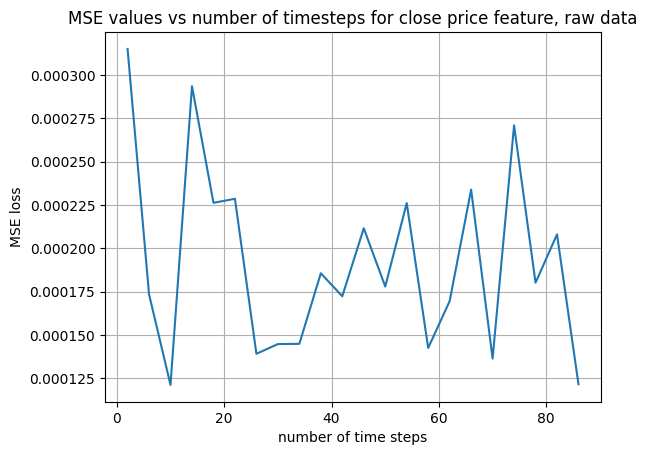

In [ ]:
# graphing the results

graph_MSE_vs_timesteps(timestep_results, MSE_results, "MSE values vs number of timesteps for close price feature, raw data")

As can be seen from the results above, best results are produced for the number of steps of around 15 days and 25 days.

### Price Deltas

In [ ]:
# now using the same approach, but loading closing price changes instead of raw data

data_arrays = [close_vals]
timestep_results, MSE_results = test_num_steps(start = 2, end = 90, step = 4, epoch_num = 50, data_array = data_arrays, data_processing_function = get_data_delta)

30/30 [==============================] - 0s 2ms/step - loss: 0.0141
0% progress
30/30 [==============================] - 0s 3ms/step - loss: 0.0149
4% progress
30/30 [==============================] - 0s 3ms/step - loss: 0.0156
9% progress
30/30 [==============================] - 0s 3ms/step - loss: 0.0101
13% progress
29/29 [==============================] - 0s 3ms/step - loss: 0.0053
18% progress
29/29 [==============================] - 0s 4ms/step - loss: 0.0053
22% progress
29/29 [==============================] - 0s 5ms/step - loss: 0.0047
27% progress
29/29 [==============================] - 0s 5ms/step - loss: 0.0054
31% progress
29/29 [==============================] - 0s 5ms/step - loss: 0.0037
36% progress
29/29 [==============================] - 0s 5ms/step - loss: 0.0031
40% progress
29/29 [==============================] - 0s 9ms/step - loss: 0.0020
45% progress
29/29 [==============================] - 0s 6ms/step - loss: 0.0047
50% progress
29/29 [========================

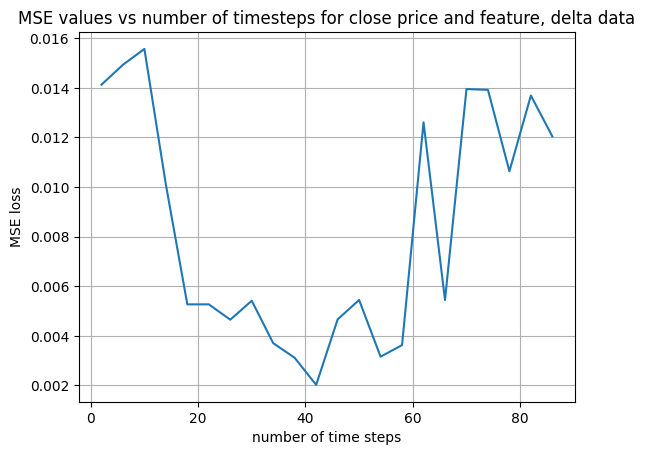

In [ ]:
graph_MSE_vs_timesteps(timestep_results, MSE_results, "MSE values vs number of timesteps for close price and feature, delta data")

## Multiple Features Prediction

Now I attempt adding additional features to see whether the optimal time step trend will change.

In [ ]:
# now we try adding volume data to the features using raw data

data_arrays = [close_vals, volume_vals]
timestep_results, MSE_results = test_num_steps(start = 2, end = 90, step = 4, epoch_num = 50, data_array = data_arrays, data_processing_function = get_data_raw)

93/93 [==============================] - 0s 2ms/step - loss: 1.2365e-04
0% progress
93/93 [==============================] - 0s 3ms/step - loss: 1.1896e-04
4% progress
93/93 [==============================] - 0s 3ms/step - loss: 1.3929e-04
9% progress
93/93 [==============================] - 1s 5ms/step - loss: 1.3801e-04
13% progress
92/92 [==============================] - 0s 3ms/step - loss: 1.6302e-04
18% progress
92/92 [==============================] - 0s 4ms/step - loss: 1.0037e-04
22% progress
92/92 [==============================] - 1s 5ms/step - loss: 1.2549e-04
27% progress
92/92 [==============================] - 1s 5ms/step - loss: 1.0685e-04
31% progress
92/92 [==============================] - 1s 7ms/step - loss: 1.0442e-04
36% progress
92/92 [==============================] - 1s 5ms/step - loss: 1.1413e-04
40% progress
92/92 [==============================] - 1s 6ms/step - loss: 9.3826e-05
45% progress
92/92 [==============================] - 1s 6ms/step - loss: 1.2195e

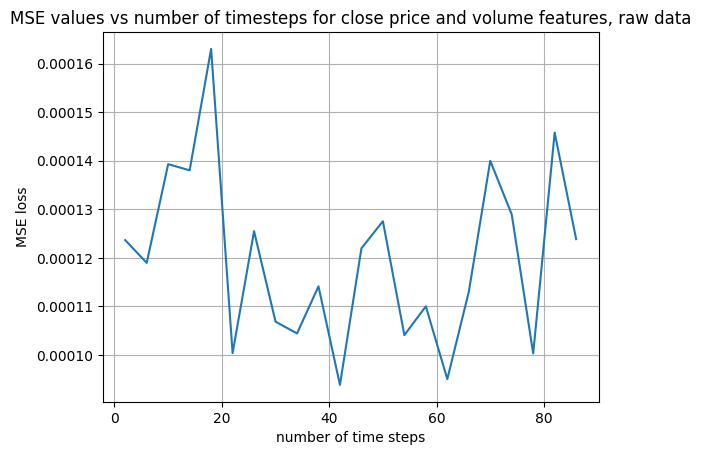

In [ ]:
graph_MSE_vs_timesteps(timestep_results, MSE_results, "MSE values vs number of timesteps for close price and volume features, raw data")

In [ ]:
# now we try adding volume data to the features using delta data

data_arrays = [close_vals, volume_vals]
timestep_results, MSE_results = test_num_steps(start = 2, end = 90, step = 4, epoch_num = 50, data_array = data_arrays, data_processing_function = get_data_delta)

93/93 [==============================] - 0s 2ms/step - loss: 0.0732
0% progress
93/93 [==============================] - 0s 2ms/step - loss: 0.0623
4% progress
93/93 [==============================] - 1s 6ms/step - loss: 0.0418
9% progress
93/93 [==============================] - 1s 4ms/step - loss: 0.0217
13% progress
92/92 [==============================] - 0s 3ms/step - loss: 0.0147
18% progress
92/92 [==============================] - 1s 5ms/step - loss: 0.0095
22% progress
92/92 [==============================] - 1s 5ms/step - loss: 0.0068
27% progress
92/92 [==============================] - 1s 4ms/step - loss: 0.0059
31% progress
92/92 [==============================] - 1s 5ms/step - loss: 0.0048
36% progress
92/92 [==============================] - 1s 4ms/step - loss: 0.0078
40% progress
92/92 [==============================] - 1s 5ms/step - loss: 0.0050
45% progress
92/92 [==============================] - 1s 5ms/step - loss: 0.0096
50% progress
92/92 [========================

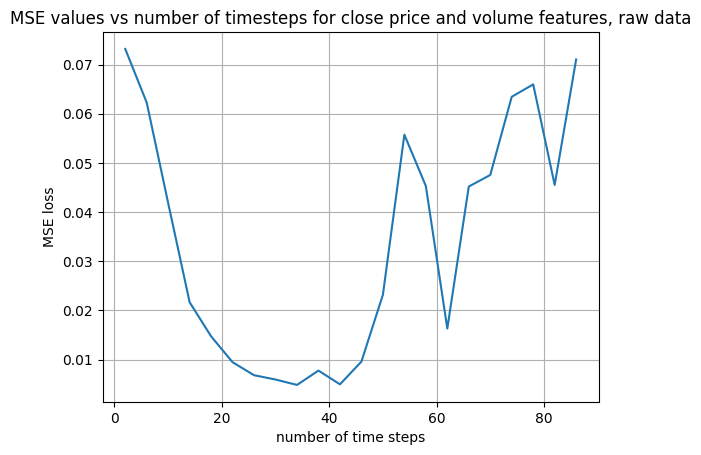

In [ ]:
graph_MSE_vs_timesteps(timestep_results, MSE_results, "MSE values vs number of timesteps for close price and volume features, raw data")

## Conclusion

From the graphs produced above we can see that the optimal number of times steps that are fed to the network to predict the price is around 40, as the lowest points of all of the 4 graphs appear for a value of time steps of around 40. Even though some of them had optimal values slighlty smaller than 40 and some of them had these values greater than 40, it is reasonable to say that these deviations appear due to the inconsistency of training relusts for such a low number of epochs, meaning that, overall, a mean value of around 40 That is why this is going to be the parameter for the time steps I will be using for the rest of the research.

Another crucial conclusion can be made about type of data fed to the network. Overall, networks that delt with raw data instead of data deltas performed better, with slighlty better results priduced by the network which not only used the close price, but also the volume. Therefore, it is reasonbale to move on to evaluating the best set of features to be used with the network.

# Evaluating the Best Set of Features

## Intro

Another crucial parameter for training a neural network is picking the relevant features. The dataset provides 6 different features, and the goal is to see which combination of those will lead to best results. The strategy for thir part is to iterate over all possible sets of features to be used to predict the price of the stock.

## Two Features

In [ ]:
two_feature_results = test_feature_set(num_features = 2, num_epochs = 100, time_step = 40, data_processing_function = get_data_raw)

65/65 [==============================] - 0s 5ms/step - loss: 1.2367e-04
20% progress
65/65 [==============================] - 0s 5ms/step - loss: 1.4213e-04
40% progress
65/65 [==============================] - 1s 7ms/step - loss: 1.2473e-04
60% progress
65/65 [==============================] - 1s 7ms/step - loss: 1.0679e-04
80% progress
65/65 [==============================] - 0s 5ms/step - loss: 1.1346e-04
100% progress


In [ ]:
two_feature_results.sort()
print(two_feature_results)
print(two_feature_results[0])

[(0.00010678591934265569, 'Close, Adj Close'), (0.00011345745588187128, 'Close, Volume'), (0.0001236729440279305, 'Close, Open'), (0.00012473356036935002, 'Close, Low'), (0.0001421304332325235, 'Close, High')]
(0.00010678591934265569, 'Close, Adj Close')


## Three Features

In [ ]:
three_feature_results = test_feature_set(num_features = 3, num_epochs = 100, time_step = 40, data_processing_function = get_data_raw)

116/116 [==============================] - 1s 3ms/step - loss: 1.2215e-04
[(0.00012214681191835552, 'Close, Open, High')]
10% progress
116/116 [==============================] - 0s 2ms/step - loss: 1.1734e-04
[(0.00012214681191835552, 'Close, Open, High'), (0.00011733963765436783, 'Close, Open, Low')]
20% progress
116/116 [==============================] - 0s 3ms/step - loss: 1.1631e-04
[(0.00012214681191835552, 'Close, Open, High'), (0.00011733963765436783, 'Close, Open, Low'), (0.00011631273082457483, 'Close, Open, Adj Close')]
30% progress
116/116 [==============================] - 0s 2ms/step - loss: 1.1696e-04
[(0.00012214681191835552, 'Close, Open, High'), (0.00011733963765436783, 'Close, Open, Low'), (0.00011631273082457483, 'Close, Open, Adj Close'), (0.00011696096771629527, 'Close, Open, Volume')]
40% progress
116/116 [==============================] - 0s 2ms/step - loss: 9.8461e-05
[(0.00012214681191835552, 'Close, Open, High'), (0.00011733963765436783, 'Close, Open, Low'), (

In [ ]:
three_feature_results.sort()
print(three_feature_results)
print(three_feature_results[0])

[(8.826652629068121e-05, 'Close, Adj Close, Volume'), (9.846078319242224e-05, 'Close, High, Low'), (0.00010334944818168879, 'Close, High, Adj Close'), (0.00010757928248494864, 'Close, High, Volume'), (0.00010761259181890637, 'Close, Low, Adj Close'), (0.00011472764163045213, 'Close, Low, Volume'), (0.00011631273082457483, 'Close, Open, Adj Close'), (0.00011696096771629527, 'Close, Open, Volume'), (0.00011733963765436783, 'Close, Open, Low'), (0.00012214681191835552, 'Close, Open, High')]
(8.826652629068121e-05, 'Close, Adj Close, Volume')


First of all, we can see that one additional feature improved the best result, which is reasonable, as more factors that may affect the price are fed to the network.

According to the results from the part with three features the best performing combinations of features are 'Close, Adj Close, Volume' and 'Close, High, Low'.

As we look at the remaining list of models, all the models which used 'Open' feature perfomred worse than all the others. It is reasonable to claim that open price may be slightly irrelevant. Open price is the price at which the first trade of the day occurs, so it often reflects the accumulation of overnight and weekend rumors, as market sentiment is shaped by unverified information and speculation outside of regular trading hours. It, therefore, may bring misleading ofnormation to the model and should be avoided.

It is reasonable to attempt to train models for 3 and more features for all possible combinations, yet, as it was outlined in the paragraph above, open price may be misleading, so it will be exluded from the list of features for this part.

## Four Features



In [ ]:
# adjusting the features for this part
all_data = [close_vals, high_vals, low_vals, adj_close_vals, volume_vals]
all_data_names = ["Close", "High", "Low", "Adj Close", "Volume"]

four_feature_results = test_feature_set(num_features = 4, num_epochs = 100, time_step = 40, data_processing_function = get_data_raw)

# returning the features to the original state
all_data = [close_vals, open_vals, high_vals, low_vals, adj_close_vals, volume_vals]
all_data_names = ["Close", "Open", "High", "Low", "Adj Close", "Volume"]

114/114 [==============================] - 1s 5ms/step - loss: 2.5081e-04
[(0.00025081480271182954, 'Close, High, Low, Adj Close')]
25% progress
114/114 [==============================] - 1s 5ms/step - loss: 2.1284e-04
[(0.00025081480271182954, 'Close, High, Low, Adj Close'), (0.00021284236572682858, 'Close, High, Low, Volume')]
50% progress
114/114 [==============================] - 1s 5ms/step - loss: 1.5594e-04
[(0.00025081480271182954, 'Close, High, Low, Adj Close'), (0.00021284236572682858, 'Close, High, Low, Volume'), (0.00015594298020005226, 'Close, High, Adj Close, Volume')]
75% progress
114/114 [==============================] - 1s 8ms/step - loss: 1.5777e-04
[(0.00025081480271182954, 'Close, High, Low, Adj Close'), (0.00021284236572682858, 'Close, High, Low, Volume'), (0.00015594298020005226, 'Close, High, Adj Close, Volume'), (0.00015776506916154176, 'Close, Low, Adj Close, Volume')]
100% progress


In [ ]:
four_feature_results.sort()
print(four_feature_results)
print(four_feature_results[0])

[(0.00015594298020005226, 'Close, High, Adj Close, Volume'), (0.00015776506916154176, 'Close, Low, Adj Close, Volume'), (0.00021284236572682858, 'Close, High, Low, Volume'), (0.00025081480271182954, 'Close, High, Low, Adj Close')]
(0.00015594298020005226, 'Close, High, Adj Close, Volume')


## Five Features

In [ ]:
# adjusting the features for this part
all_data = [close_vals, high_vals, low_vals, adj_close_vals, volume_vals]
all_data_names = ["Close", "High", "Low", "Adj Close", "Volume"]

five_feature_results = test_feature_set(num_features = 5, num_epochs = 100, time_step = 40, data_processing_function = get_data_raw)

# returning the features to the original state
all_data = [close_vals, open_vals, high_vals, low_vals, adj_close_vals, volume_vals]
all_data_names = ["Close", "Open", "High", "Low", "Adj Close", "Volume"]

135/135 [==============================] - 1s 5ms/step - loss: 1.9056e-04
[(0.00019055783923249692, 'Close, High, Low, Adj Close, Volume')]
100% progress


In [ ]:
five_feature_results.sort()
print(five_feature_results)
print(five_feature_results[0])

[(0.00019055783923249692, 'Close, High, Low, Adj Close, Volume')]
(0.00019055783923249692, 'Close, High, Low, Adj Close, Volume')


## Conclusion

As can be seen from the results for different number of features, the most succesful models are the ones that use three features. That most likely happens due to the model's inability to focus on important features when there is a great varity of them, forcing the model to potential overfitting. It is, therefore, reasonable to use 'Close', "Adj Close' and 'Volume' features for future model training.

# Structure of the Neural Network

## Intro

In this part of the research I evaluate the most efficient structure of the neural network. Since the learning process take extremely large amounts of time for this neural network, the layer structure of the network is simplified to just one RNN layer and one output layer. The goal of this part of the project is to see how the number of units in RNN layer affects the performance. This will be done by training networks with different number of units and comparing the results.

## Evaluating the Optimal Number of Units on a Large Scale

In [ ]:
# obtaining the results for different number of units

large_num_units_results = test_number_units(start = 5, end = 300, step = 30, num_epochs = 10, data_array = [close_vals, adj_close_vals, volume_vals])

116/116 [==============================] - 1s 5ms/step - loss: 1.7452e-04
10% progress
116/116 [==============================] - 1s 5ms/step - loss: 9.8096e-05
20% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.4302e-04
30% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.1761e-04
40% progress
116/116 [==============================] - 1s 7ms/step - loss: 2.1161e-04
50% progress
116/116 [==============================] - 1s 9ms/step - loss: 1.0414e-04
61% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.2075e-04
71% progress
116/116 [==============================] - 32s 5ms/step - loss: 1.7585e-04
81% progress
116/116 [==============================] - 1s 8ms/step - loss: 1.1705e-04
91% progress
116/116 [==============================] - 1s 8ms/step - loss: 1.1112e-04
101% progress


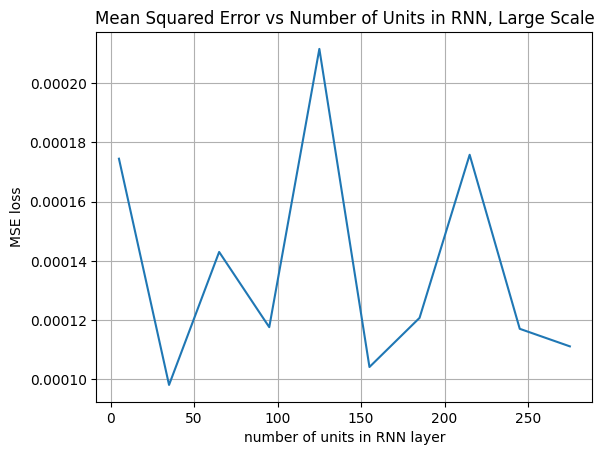

In [ ]:
# plotting the results
graph_MSE_vs_num_units(large_num_units_results, "Mean Squared Error vs Number of Units in RNN, Large Scale")

In [ ]:
# obtaining top 3 values

large_num_units_results.sort()
print(large_num_units_results[ : 3])

[(9.8096439614892e-05, 35), (0.00010414481221232563, 155), (0.00011112271749880165, 275)]


It is clear from the results that there are some ranges for the number of units, for which the neural network performs better. Those incluse the range around 35 units and the range around 155 units (there is also a decent results for 275, but at this point the network is most likely extremely complicated and).

## Evaluating the Optimal Number of Units on a Small Scale

In [ ]:
# obtaining the results for different number of units

small_num_units_results_1 = test_number_units(start = 20, end = 50, step = 5, num_epochs = 10, data_array = [close_vals, adj_close_vals, volume_vals])

116/116 [==============================] - 1s 8ms/step - loss: 1.2046e-04
16% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.5037e-04
33% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.1278e-04
50% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.2527e-04
66% progress
116/116 [==============================] - 1s 6ms/step - loss: 1.2861e-04
83% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.2074e-04
100% progress


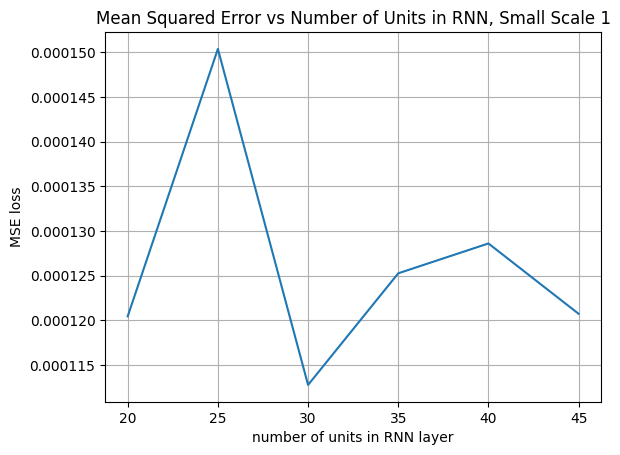

In [ ]:
# plotting the results
graph_MSE_vs_num_units(small_num_units_results_1, "Mean Squared Error vs Number of Units in RNN, Small Scale 1")

In [ ]:
# obtaining top 3 values

small_num_units_results_1.sort()
print(small_num_units_results_1[ : 3])

[(0.00011278290912741795, 30), (0.00012045714538544416, 20), (0.00012073999096173793, 45)]


In [ ]:
# obtaining the results for different number of units

small_num_units_results_2 = test_number_units(start = 140, end = 170, step = 5, num_epochs = 10, data_array = [close_vals, adj_close_vals, volume_vals])

116/116 [==============================] - 1s 7ms/step - loss: 1.0376e-04
16% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.4122e-04
33% progress
116/116 [==============================] - 1s 6ms/step - loss: 1.1057e-04
50% progress
116/116 [==============================] - 1s 7ms/step - loss: 1.5859e-04
66% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.6969e-04
83% progress
116/116 [==============================] - 1s 5ms/step - loss: 1.2771e-04
100% progress


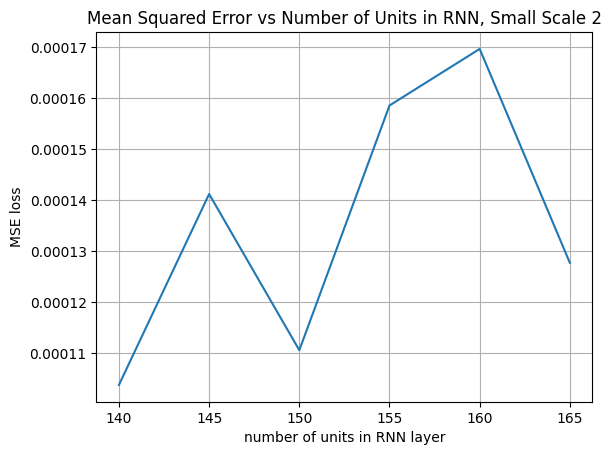

In [ ]:
# plotting the results
graph_MSE_vs_num_units(small_num_units_results_2, "Mean Squared Error vs Number of Units in RNN, Small Scale 2")

In [ ]:
# obtaining top 3 values

small_num_units_results_2.sort()
print(small_num_units_results_2[ : 3])

[(0.0001037597976392135, 140), (0.00011057496158173308, 150), (0.00012771420006174594, 165)]


## Conclusion

We can see that on a smaller scale both ranges of values perform similarly. It is reasonable to claim that the network with larger number of units was able to notice a more complex correlation between the data. Therefore, there is a potential that the performance of the 140 units network will be inmproved with longer training times, so that is the value I will be using in the future.

# Evaluating the Final Model

## Intro

In this part I apply all the results obtained from previous part to create, train and evaluate the best-performing model.

## Training the Model

In [30]:
# preparing the data
X, y = get_data_raw([close_vals, adj_close_vals, volume_vals], 40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# creating a model
model_final = Sequential()
model_final.add(SimpleRNN(units = 140, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
model_final.add(Dense(units = 1))
model_final.compile(optimizer = 'adam', loss = 'mean_squared_error')

# training the model
model_final.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 1)

Epoch 1/100
464/464 [==============================] - 21s 32ms/step - loss: 0.0011
Epoch 2/100
464/464 [==============================] - 14s 31ms/step - loss: 1.8587e-04
Epoch 3/100
464/464 [==============================] - 15s 32ms/step - loss: 1.4208e-04
Epoch 4/100
464/464 [==============================] - 14s 30ms/step - loss: 1.3318e-04
Epoch 5/100
464/464 [==============================] - 13s 27ms/step - loss: 1.3291e-04
Epoch 6/100
464/464 [==============================] - 14s 30ms/step - loss: 1.2119e-04
Epoch 7/100
464/464 [==============================] - 15s 31ms/step - loss: 1.2780e-04
Epoch 8/100
464/464 [==============================] - 14s 31ms/step - loss: 1.2983e-04
Epoch 9/100
464/464 [==============================] - 14s 31ms/step - loss: 1.2475e-04
Epoch 10/100
464/464 [==============================] - 14s 31ms/step - loss: 1.2827e-04
Epoch 11/100
464/464 [==============================] - 13s 27ms/step - loss: 1.2785e-04
Epoch 12/100
464/464 [============

## Mean Squared Error Loss on Testing Set

In [ ]:
print("Mean Squared Error on the Testing Set is", model_final.evaluate(X_test, y_test))

116/116 [==============================] - 1s 5ms/step - loss: 1.1354e-04
Mean Squared Error on the Testing Set is  0.00011353728041285649


## Directional Accuracy Evaluation

In [ ]:
dir_accuracy = get_directional_accuracy(model_final, [close_vals, adj_close_vals, volume_vals])
print("Directional Accuracy of the Model is " + str(round(100 * dir_accuracy, 2)) + "%")

Directional Accuracy of the Model is 87.29%


## Trading Strategy Profit

### Random Stock

In [45]:
# obtaining the results for 3 random stocks

avg_annual_profit_rand, avg_ROI_rand, avg_annual_return_rand = get_avergage_profit_random_stocks(model_final, 3, "/content/drive/MyDrive/Colab Notebooks/stocks")

Stock: CBSHP
Return On Investment: 11.1%
Annual Return: 2.74%
Annual Profit: 9.55$

Stock: CINR
Return On Investment: 11.11%
Annual Return: 2.42%
Annual Profit: 10.27$

Stock: BKTI
Return On Investment: 30.71%
Annual Return: 0.98%
Annual Profit: 4.11$



In [46]:
# printing the average results

print("Return On Investment: " + str(round(100 * avg_ROI_rand, 2)) + "%")
print("Annual Return: " + str(round(100 * avg_annual_return_rand, 2)) + "%")
print("Annual Profit: " + str(round(avg_annual_profit_rand, 2)) + "$")

Return On Investment: 17.64%
Annual Return: 2.05%
Annual Profit: 7.98$


### Microsoft, Amazon, Tesla Stocks

#### Obtaining the Results

In [31]:
annual_profit_MSFT, ROI_MSFT, annual_return_MSFT = get_average_profit_specific_stock(model_final, "/content/drive/MyDrive/Colab Notebooks/stocks", "MSFT")
annual_profit_AMZN, ROI_AMZN, annual_return_AMZN = get_average_profit_specific_stock(model_final, "/content/drive/MyDrive/Colab Notebooks/stocks", "AMZN")
annual_profit_TSLA, ROI_TSLA, annual_return_TSLA = get_average_profit_specific_stock(model_final, "/content/drive/MyDrive/Colab Notebooks/stocks", "TSLA")

#### Return On Investment Values

In [32]:
print("Return On Investment for Microsoft: " + str(round(100 * ROI_MSFT, 2)) + "%")
print("Return On Investment for Amazon: " + str(round(100 * ROI_AMZN, 2)) + "%")
print("Return On Investment for Tesla: " + str(round(100 * ROI_TSLA, 2)) + "%")

Return On Investment for Microsoft: 9.75%
Return On Investment for Amazon: 14.98%
Return On Investment for Tesla: 28.92%


#### Annual Return Values


In [33]:
print("Annual Return for Microsoft: " + str(round(100 * annual_return_MSFT, 2)) + "%")
print("Annual Return for Amazon: " + str(round(100 * annual_return_AMZN, 2)) + "%")
print("Annual Return for Tesla: " + str(round(100 * annual_return_TSLA, 2)) + "%")

Annual Return for Microsoft: 0.4%
Annual Return for Amazon: 0.9%
Annual Return for Tesla: 3.91%


#### Annual Profit Values

In [34]:
print("Annual Profit for Microsoft: " + str(round(annual_profit_MSFT, 2)) + "$")
print("Annual Profit for Amazon: " + str(round(annual_profit_AMZN, 2)) + "$")
print("Annual Profit for Tesla: " + str(round(annual_profit_TSLA, 2)) + "$")

Annual Profit for Microsoft: 2.8$
Annual Profit for Amazon: 5.57$
Annual Profit for Tesla: 10.05$


## Conclusion

As can be seen from the results obtained in model evaluation, it is relatively good at prediction stock prices. Directional accuracy of around 87% demonstrates model's capability of correctly identifying trends in prices. The other metrics used in this parts have their pros and cons. My main goal was to present them to give a better understanding of the effectiveness of the model. As can be seen from the results, all the additional metrics have positive results, meaning that the network provides the user with relatively safe trading advice. However, there are some flaws in the metrics. ROI is good at demonstrating total profit, but does not consider period, over which it was earned. Annual profit is crucially affected by the number of stocks that should be bough according to the stratgey (by default it is 1, so the annual profit number are not that impressive). Finally, annual return metric provides us with more or less understandable and easy to interpret data, which reflects on the effectiveness of the neural network. However, even this parameter is crucially affected by the trading strategy the neural network is used with. Since here the trading strategy is relatively basic, annual returns are positive, showing stability in predictions, yet not as large as desired, due to the simplicity of the strategy. Nevertheless, all the metricts in all tests had positive values, making it reasonable to conclude that the network is generally successful at predicting stock prices and the key to increasing the profit from trading lies in the field trading strategies, used with the model.

# Conclusions

Throughout the research I was able to obtain a number of interesting conclusion about the usage of RNNs for stock price prediction.

It all started with the evaluation of the optimal number of timesteps needed for the model for its predictions. As the graph data showed, the best results are reached when the model knows about the data for the past 40 days, which is quite a peculiar result. It means that the data that is older than 40 days becomes slightly irrelevant and starts to distract the model from the recent and more relevant to the predictions data. Yet having information about less than 40 days also decreases the accuracy of the predictions. Reverse engineering can be conducted here to cocnlude that 40 day period can be considered the most valuable and impactful for stock trading.

Another fascinating conclusion is that RNN works worse with data that is reprsented as deltas (value changes instead of raw values). However, this can be explained by the idea that deltas are effectively one day derivatives for the price data. They do not bring any new information to the dataset, yet due to them the network loses information about absolute price values, which can be extremely relevant.

Another challenging task was to pick a set of features which would result in the best performance. The approach was direct: try all possible combinations and obtain compare results. As the performance improved after moving from 1 to 2 features and then from 2 to 3, I exepected that feeding more data will simply continue to inprove the results. However, the MSEs obtaining for 4 and 5 features turned out to be worse than the ones produced by best combinations of 3 features. That happened most likely due to some of the price information being effectively duplicating, as all of the price data is to some extent interconnected. That is why in the best set of features there is only two price features. It is also easy to see why Volume was among the parameters in the best feature set, as it provides the model with type of data, which is not reflected in prices. Finally, Open Price turned out to be extremely irrelevant due to market volatility in the beginning of the reading day.

It was also insightful to find optimal numbers of units needed for the RNN layer. The results, contrary to the assumprion that there will be some specific number that would provide the best performance, seem to show that there is actually two such ranges of values. We can explain that by thinking about the role of units in the RNN layer. The more units there are in the layer, the more complex patterns the neural network can detect and use in its predictions. Therefore, larger numbers of units are most likely responsible for more complex patterns that may lead to better results, but will most likely require longer training.

Finally, apart from obtaining a relatively low value of MSE (of an order of ten to the power of negative 4), the model performed well on the directional tests, correctly predicting the direction of the trend of the stock price in around 87% of cases. Apart from that, the results obtained from applying a basic trading strategy to the model are also satisfactory. They are based on extremely simple trading strategy with a fix investment of one stock each time, so the magnitudes are not too representative. What is much more important is that te results are positive for the stocks used, making it a relatively safe investment strategy. This makes this model somewhat useful in real life.